# Seldon deployment of Alibi Outlier detector


This tutorial picks up when the [alibi anchor explainer](../../explainers/alibi_anchor_tabular/alibi_anchor_tabular_seldon_deployment.ipynb) left off.

Tne objective of this tutorial is to build a "loan approval" classifier equiped with the outliers detector from [alibi-detect](https://github.com/SeldonIO/alibi-detect) package.
The diagram of this tutorial is as follows:

![deploy-overview](./img/deploy-overview.jpg)

In this tutorial we will follow the following steps:

1) Train a detector to look for outliers in the incoming data

2) Containerise and deploy your detector

3) Train a model to predict loan approvals

4) Containerise and deploy your model

5) Test your new loanclassifier deployment with outliers detection


## Before you start
Make sure you install the following dependencies, as they are critical for this example to work:

* Helm v3.0.0+
* A Kubernetes cluster running v1.13 or above (minkube / docker-for-windows work well if enough RAM)
* kubectl v1.14+
* ksonnet v0.13.1+
* kfctl 0.5.1 - Please use this exact version as there are major changes every few months
* Python 3.6+
* Python DEV requirements (we'll install them below)

You can follow this [notebook](../../../notebooks/seldon_core_setup.ipynb) to setup your cluster.

Let's get started! 🚀🔥 


## Install python dependencies

In [1]:
!cat requirements-dev.txt

xai==0.0.5
seldon_core==0.5.1
alibi==0.3.2
dill==0.3.1
scikit-learn==0.20.1
alibi-detect==0.2.0


In [3]:
# !pip install -r requirements-dev.txt

## Setup Seldon Core

Use the setup notebook to [Setup Cluster](../../seldon_core_setup.ipynb#Setup-Cluster) with [Ambassador Ingress](../../seldon_core_setup.ipynb#Ambassador) and [Install Seldon Core](../../seldon_core_setup.ipynb#Install-Seldon-Core). Instructions [also online](./seldon_core_setup.html).

## 1) Train a detector to look for outliers in the incoming data

### Imports

In [4]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

from alibi_detect.od import IForest
from alibi_detect.datasets import fetch_kdd
from alibi_detect.utils.data import create_outlier_batch
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [5]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

### Get data

In [6]:
import alibi

adult = alibi.datasets.fetch_adult()

data = adult.data
target = adult.target
feature_names = adult.feature_names
category_map = adult.category_map

### Prepare data preprocessor 

In [7]:
ordinal_features = [x for x in range(len(feature_names)) if x not in list(category_map.keys())]
ordinal_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                      ('scaler', StandardScaler())])

outliers_preprocessor = ColumnTransformer(transformers=[('num', ordinal_transformer, ordinal_features)])
outliers_preprocessor.fit(data)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))]), [0, 8, 9, 10])])

### Train on normal data

In [8]:
np.random.seed(0)
normal_batch = create_outlier_batch(data, target, n_samples=30000, perc_outlier=0)
X_train, y_train = normal_batch.data.astype('float'), normal_batch.target

In [9]:
X_train = outliers_preprocessor.transform(X_train)

In [10]:
# initialize outlier detector
od = IForest(threshold=None,  # threshold for outlier score
             n_estimators=100)

# train
od.fit(X_train)

/home/rskolasinski/.local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/rskolasinski/.local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


### Train on threshold data

In [11]:
np.random.seed(0)
perc_outlier = 5
threshold_batch = create_outlier_batch(data, target, n_samples=1000, perc_outlier=perc_outlier)
X_threshold, y_threshold = threshold_batch.data.astype('float'), threshold_batch.target
X_threshold = outliers_preprocessor.transform(X_threshold)

In [12]:
od.infer_threshold(X_threshold, threshold_perc=100 - perc_outlier)
print('New threshold: {}'.format(od.threshold))

New threshold: 0.10840005025210257


### Outlier data

In [13]:
np.random.seed(1)
outlier_batch = create_outlier_batch(data, target, n_samples=1000, perc_outlier=10)
X_outlier, y_outlier = outlier_batch.data.astype('float'), outlier_batch.target
X_outlier = outliers_preprocessor.transform(X_outlier)

In [14]:
print(X_outlier.shape, y_outlier.shape)
print('{}% outliers'.format(100 * y_outlier.mean()))

(1000, 4) (1000,)
10.0% outliers


F1 score: 0.32704402515723274


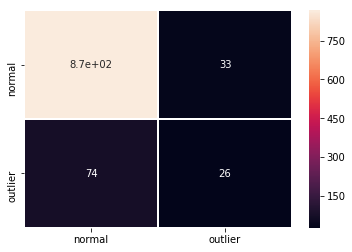

In [17]:
od_preds = od.predict(X_outlier, return_instance_score=True)

labels = outlier_batch.target_names
y_pred = od_preds['data']['is_outlier']
f1 = f1_score(y_outlier, y_pred)
print('F1 score: {}'.format(f1))
cm = confusion_matrix(y_outlier, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, cbar=True, linewidths=.5)
plt.show()

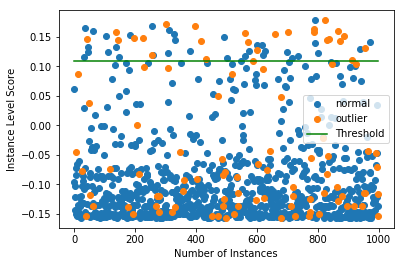

In [18]:
plot_instance_score(od_preds, y_outlier, labels, od.threshold)

## 2) Containerise and deploy your detector

In [19]:
!mkdir -p pipeline/pipeline_steps/outliers-detector

### 2.1 - Save the trained model in the folder

In [20]:
import dill

with open("pipeline/pipeline_steps/outliers-detector/preprocessor.dill", "wb") as prep_f:
    dill.dump(outliers_preprocessor, prep_f)
    
with open("pipeline/pipeline_steps/outliers-detector/model.dill", "wb") as model_f:
    dill.dump(od, model_f)

### 2.2 Write a python wrapper for the outlier detector

In [21]:
%%writefile pipeline/pipeline_steps/outliers-detector/Detector.py
import dill
import json
import numpy as np


class Detector:
    def __init__(self, *args, **kwargs):
        
        with open("preprocessor.dill", "rb") as prep_f:
            self.preprocessor = dill.load(prep_f)
        with open("model.dill", "rb") as model_f:
            self.od = dill.load(model_f)
        
    def predict(self, X, feature_names=[]):
        print("Received: " + str(X))
        X_prep = self.preprocessor.transform(X)
        od_preds = self.od.predict(X_prep, return_instance_score=True)
        print("Predicted: " + str(od_preds))
        return json.dumps(od_preds, cls=NumpyEncoder)
    

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, (
        np.int_, np.intc, np.intp, np.int8, np.int16, np.int32, np.int64, np.uint8, np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)    

Overwriting pipeline/pipeline_steps/outliers-detector/Detector.py


### 2.3 Add the python requirements

In [22]:
%%writefile pipeline/pipeline_steps/outliers-detector/requirements.txt
scikit-learn==0.20.1
dill==0.3.1.
alibi==0.3.2
seldon-core==0.5.1
alibi-detect==0.2.0

Overwriting pipeline/pipeline_steps/outliers-detector/requirements.txt


### 2.4 Add the Source2Image configuration so the script knows which Model.py to use

In [23]:
!mkdir pipeline/pipeline_steps/outliers-detector/.s2i

mkdir: cannot create directory ‘pipeline/pipeline_steps/outliers-detector/.s2i’: File exists


In [24]:
%%writefile pipeline/pipeline_steps/outliers-detector/.s2i/environment
MODEL_NAME=Detector
API_TYPE=REST
SERVICE_TYPE=MODEL
PERSISTENCE=0

Overwriting pipeline/pipeline_steps/outliers-detector/.s2i/environment


### 2.5 Run the s2i command to build the image

In [25]:
# !s2i build pipeline/pipeline_steps/outliers-detector seldonio/seldon-core-s2i-python37:0.14 outliers-detector:0.1

*or* if using Minikube

In [26]:
# %%bash
# eval $(minikube docker-env)
# !build pipeline/pipeline_steps/outliers-detector seldonio/seldon-core-s2i-python37:0.14 outliers-detector:0.1

### 2.6 Deploy your image with a Seldon Graph Definition

In [27]:
%%writefile pipeline/pipeline_steps/outliers-detector/outliers-detector.yaml
apiVersion: machinelearning.seldon.io/v1alpha2
kind: SeldonDeployment
metadata:
  labels:
    app: seldon
  name: outliers-detector
spec:
  name: outliers-detector
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - image: rafalskolasinski/seldon-experiments:outliers-detector-0.1
          name: model-outliers
          imagePullPolicy: Always
    graph:
      children: []
      name: model-outliers
      type: MODEL
      endpoint:
        type: REST
    name: outliers-detector
    replicas: 1


Overwriting pipeline/pipeline_steps/outliers-detector/outliers-detector.yaml


In [28]:
!kubectl apply -f pipeline/pipeline_steps/outliers-detector/outliers-detector.yaml

seldondeployment.machinelearning.seldon.io/outliers-detector configured


In [29]:
!kubectl get pods

NAME                                                              READY   STATUS    RESTARTS   AGE
ambassador-69d88f894c-28xr2                                       1/1     Running   0          45h
ambassador-69d88f894c-9w685                                       1/1     Running   0          45h
ambassador-69d88f894c-dlc9z                                       1/1     Running   0          45h
loanclassifier-explainer-loanclassifier-explainer-d73a620-2gkgl   2/2     Running   0          44h
loanclassifier-loanclassifier-796f306-694bc55488-n8btk            2/2     Running   0          45h
loanclassifier-outliers-loanclassifier-outliers-e337bcf-5d65s52   2/2     Running   0          7m7s
outliers-detector-outliers-detector-4f22c89-6f9cb776d8-dkmzp      2/2     Running   0          38m


### 2.7 Now that it's deployed we can query it
**IMPORTANT:** If you are using minikube (instead of docker desktop) you have to forward the port first with:
```
kubectl port-forward svc/ambassador 8003:80
```

#### First we can try Curl

In [30]:
data[:1]

array([[  39,    7,    1,    1,    1,    1,    4,    1, 2174,    0,   40,
           9]])

In [31]:
%%bash
curl -X POST -H 'Content-Type: application/json' \
    -d "{'data': {'names': ['text'], 'ndarray': [[39, 7, 1, 1, 1, 1, 4, 1, 2174, 0, 40, 9]] }}" \
    http://localhost:8003/seldon/seldon/outliers-detector/api/v0.1/predictions

{
  "meta": {
    "puid": "sliovk4ijihujshqnfrb46s371",
    "tags": {
    },
    "routing": {
    },
    "requestPath": {
      "model-outliers": "rafalskolasinski/seldon-experiments:outliers-detector-0.1"
    },
    "metrics": []
  },
  "strData": "{\"data\": {\"feature_score\": null, \"instance_score\": [0.0035157170373933955], \"is_outlier\": [0]}, \"meta\": {\"name\": \"IForest\", \"detector_type\": \"offline\", \"data_type\": \"tabular\"}}"
}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   537  100   451  100    86   1555    296 --:--:-- --:--:-- --:--:--  1845


which we can compare with calling our detector in notebook

### 2.8 Test outlier detection with Seldon Client

In [32]:
from seldon_core.seldon_client import SeldonClient
import json

In [33]:
sc = SeldonClient(
    gateway="ambassador", 
    deployment_name="outliers-detector",
    gateway_endpoint="localhost:8003",
    payload_type="ndarray",
    namespace="seldon",
    transport="rest"
)

In [34]:
to_explain = data[:1]

resp = sc.predict(data=to_explain)
json.loads(resp.response.strData)

{'data': {'feature_score': None,
  'instance_score': [0.0035157170373933955],
  'is_outlier': [0]},
 'meta': {'name': 'IForest',
  'detector_type': 'offline',
  'data_type': 'tabular'}}

which we can compare with outlier detector defined in our notebook

In [35]:
od.predict(outliers_preprocessor.transform(data[:1]), return_instance_score=True)

{'data': {'feature_score': None,
  'instance_score': array([0.00351572]),
  'is_outlier': array([0])},
 'meta': {'name': 'IForest',
  'detector_type': 'offline',
  'data_type': 'tabular'}}

## 3)  Train a model to predict loan approvals

### Split data into train and test data

In [36]:
adult = alibi.datasets.fetch_adult()

data = adult.data
labels = adult.target
feature_names = adult.feature_names
category_map = adult.category_map

# define train and test set
np.random.seed(0)
data_perm = np.random.permutation(np.c_[data, labels])
data = data_perm[:, :-1]
labels = data_perm[:, -1]

idx = 30000
X_train, y_train = data[:idx, :], labels[:idx]
X_test, y_test = data[idx + 1:, :], labels[idx + 1:]

### Imports

In [37]:
from sklearn.ensemble import RandomForestClassifier

### Add classifier preprocessor

In [38]:
categorical_features = list(category_map.keys())
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])

classifier_preprocessor = ColumnTransformer(transformers=[('num', ordinal_transformer, ordinal_features),
                                                          ('cat', categorical_transformer, categorical_features)])

In [39]:
classifier_preprocessor.fit(data)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))]), [0, 8, 9, 10]), ('cat', Pipeline(memory=None,
     steps=[(...oat64'>, handle_unknown='ignore',
       n_values=None, sparse=True))]), [1, 2, 3, 4, 5, 6, 7, 11])])

### Prepare model

In [40]:
np.random.seed(0)
clf = RandomForestClassifier(n_estimators=50)
clf.fit(classifier_preprocessor.transform(X_train), y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

,target
precision,0.708042
recall,0.661765
specificity,0.914271
accuracy,0.853906
auc,0.788018
f1,0.684122


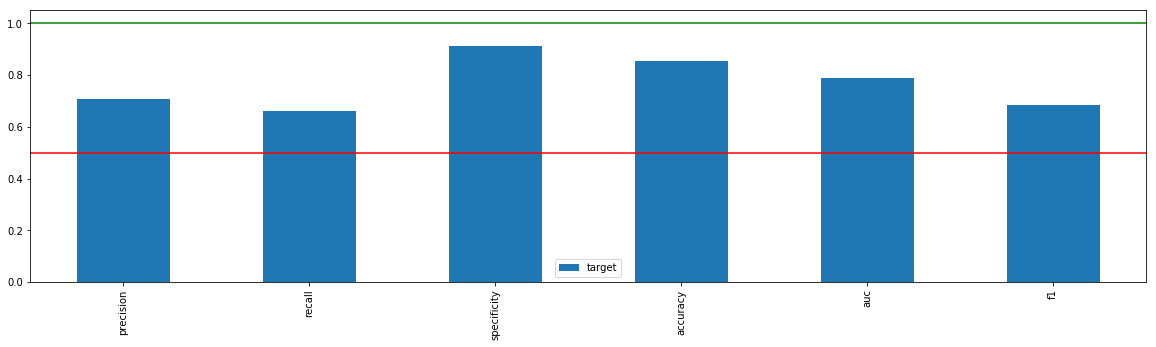

In [41]:
import xai
pred = clf.predict(classifier_preprocessor.transform(X_test))
xai.metrics_plot(y_test, pred)

## 4) Containerise and deploy model (with outliers detector)

Let's start containerising it - we'll be using the following folder for this:

In [42]:
!mkdir pipeline/pipeline_steps/loanclassifier-outliers/

mkdir: cannot create directory ‘pipeline/pipeline_steps/loanclassifier-outliers/’: File exists


### 4.1 Save the trained model in the folder

In [43]:
import dill

with open("pipeline/pipeline_steps/loanclassifier-outliers/preprocessor.dill", "wb") as prep_f:
    dill.dump(classifier_preprocessor, prep_f)
    
with open("pipeline/pipeline_steps/loanclassifier-outliers/model.dill", "wb") as model_f:
    dill.dump(clf, model_f)

### 4.2 Write a python wrapper for the loan approval model

In [75]:
%%writefile pipeline/pipeline_steps/loanclassifier-outliers/Model.py

import dill
import json

from seldon_core.seldon_client import SeldonClient
from seldon_core.utils import get_data_from_proto


class Model:

    def __init__(self, *args, **kwargs):
        self._tags = {}
        
        with open("preprocessor.dill", "rb") as prep_f:
            self.preprocessor = dill.load(prep_f)
        with open("model.dill", "rb") as model_f:
            self.clf = dill.load(model_f)
        
    def predict(self, X, feature_names=[]):
        """Run input X through loanclassifier model.
        
        Additionaly, query outliers-detector to check
        if the input X contains any outliers. Output from
        this check will be return through metadata.
        """
        
        print("Received: " + str(X))
        X_prep = self.preprocessor.transform(X)
        proba = self.clf.predict_proba(X_prep)
        print("Predicted: " + str(proba))
        
        outliers = self.detect_remote_fn(X)
        self._tags['outlier_score'] = list(outliers['data']['instance_score'])
        self._tags['outlier_verdict'] = list(outliers['data']['is_outlier'])
        
        return proba    
    
    def tags(self):
        return self._tags
    
    def detect_remote_fn(self, X):
        """Detect if input data is outliers.
        
        This function queries separately deployed component
        to check whether input data contains outliers or not.
        """
        kwargs = {
            "gateway": "ambassador", 
            "gateway_endpoint": "ambassador:80",
            "deployment_name": "outliers-detector",
            "payload_type": "ndarray",
            "namespace": "seldon",
            "transport": "rest"
        }

        sc = SeldonClient(**kwargs)
        prediction = sc.predict(data=X)
        
        return json.loads(prediction.response.strData)

Overwriting pipeline/pipeline_steps/loanclassifier-outliers/Model.py


### 4.2 Add the python requirements

In [76]:
%%writefile pipeline/pipeline_steps/loanclassifier-outliers/requirements.txt
scikit-learn==0.20.1

scipy==1.1.0
numpy==1.15.4

dill==0.3.1
seldon-core==0.5.1

Overwriting pipeline/pipeline_steps/loanclassifier-outliers/requirements.txt


### 4.3 Add the Source2Image configuration so the script knows which Model.py to use

In [77]:
!mkdir pipeline/pipeline_steps/loanclassifier-outliers/.s2i

mkdir: cannot create directory ‘pipeline/pipeline_steps/loanclassifier-outliers/.s2i’: File exists


In [78]:
%%writefile pipeline/pipeline_steps/loanclassifier-outliers/.s2i/environment
MODEL_NAME=Model
API_TYPE=REST
SERVICE_TYPE=MODEL
PERSISTENCE=0

Overwriting pipeline/pipeline_steps/loanclassifier-outliers/.s2i/environment


### 4.4 Run the s2i command to build the image

In [79]:
# !s2i build pipeline/pipeline_steps/loanclassifier-combined seldonio/seldon-core-s2i-python37:0.14 loanclassifier-combined:0.1

*or* if using Minikube

In [49]:
# %%bash
# eval $(minikube docker-env)

### 4.5 Deploy your image with a Seldon Graph Definition

In [50]:
%%writefile pipeline/pipeline_steps/loanclassifier-outliers/loanclassifier-outliers.yaml
apiVersion: machinelearning.seldon.io/v1alpha2
kind: SeldonDeployment
metadata:
  labels:
    app: seldon
  name: loanclassifier-outliers
spec:
  name: loanclassifier-outliers
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - image: rafalskolasinski/seldon-experiments:loanclassifier-outliers-0.1
          name: model-outliers
          imagePullPolicy: Always
    graph:
      children: []
      name: model-outliers
      type: MODEL
      endpoint:
        type: REST
    name: loanclassifier-outliers
    replicas: 1

Overwriting pipeline/pipeline_steps/loanclassifier-outliers/loanclassifier-outliers.yaml


In [81]:
!kubectl apply -f pipeline/pipeline_steps/loanclassifier-outliers/loanclassifier-outliers.yaml

seldondeployment.machinelearning.seldon.io/loanclassifier-outliers created


In [83]:
!kubectl get pods

NAME                                                              READY   STATUS    RESTARTS   AGE
ambassador-69d88f894c-28xr2                                       1/1     Running   0          45h
ambassador-69d88f894c-9w685                                       1/1     Running   0          45h
ambassador-69d88f894c-dlc9z                                       1/1     Running   0          45h
loanclassifier-explainer-loanclassifier-explainer-d73a620-2gkgl   2/2     Running   0          45h
loanclassifier-loanclassifier-796f306-694bc55488-n8btk            2/2     Running   0          45h
loanclassifier-outliers-loanclassifier-outliers-e337bcf-5dsm8jl   2/2     Running   0          82s
outliers-detector-outliers-detector-4f22c89-6f9cb776d8-dkmzp      2/2     Running   0          62m


## 5) Test deployement using seldon client

**IMPORTANT:** If you are using minikube (instead of docker desktop) you have to forward the port first with:
```
kubectl port-forward svc/ambassador 8003:80
```

In [84]:
from seldon_core.seldon_client import SeldonClient

In [85]:
sc = SeldonClient(
    gateway="ambassador", 
    deployment_name="loanclassifier-outliers",
    gateway_endpoint="localhost:8003",
    payload_type="ndarray",
    namespace="seldon",
    transport="rest"
)

In [86]:
to_explain = X_test[:1]

prediction = sc.predict(data=to_explain)

In [87]:
to_explain

array([[52,  4,  0,  2,  8,  4,  2,  0,  0,  0, 60,  9]])

In [88]:
prediction.response.data

names: "t:0"
names: "t:1"
ndarray {
  values {
    list_value {
      values {
        number_value: 0.86
      }
      values {
        number_value: 0.14
      }
    }
  }
}

In [89]:
prediction.response.meta

puid: "7j79l5kqkde854l3qq7q7j6lt2"
tags {
  key: "outlier_score"
  value {
    list_value {
      values {
        number_value: -0.04721613112811712
      }
    }
  }
}
tags {
  key: "outlier_verdict"
  value {
    list_value {
      values {
        number_value: 0.0
      }
    }
  }
}
requestPath {
  key: "model-outliers"
  value: "rafalskolasinski/seldon-experiments:loanclassifier-outliers-0.1"
}